# Mock for Song

Ran with MDPL. Were able to match the SMF. But with that bestfit, clustering was way off - ~5x more clustering in HSC than in the sim.

Now trying with SMDPL from the UM - this should have better clustering because the UM tracks disrupted halos. (It doesn't - we probably have a bug)

**Bugs to check**
1) One of our clustering estimates is wrong. (no, corrfunc and halotools argree in the theory case and corrfunc and my func agree in the obs case)
2) We are using MPc in one of theory/obs and MPc/h in the other (no cosmo.comovingDistance gives MPc/h and SMDPL distances are in /h)

## Import etc...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee


from get_sm_for_sim import get_sm_for_sim, _sanity_get_sm_for_sim, get_smf
import get_obs_params as gop
import likelihood as l
import clustering as c

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# Load data

In [14]:
sim_data = gop.load_smdpl()

Remember to change sim size to 400


In [33]:
obs_smf = gop.load_smf()
gals = gop.load_gals()

# Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
#params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
b_params = [12.52, 10.91, 0.6] # Fix beta and gamma
s_params = [-0.06, 1.08]

# Starting params for bestfit on just the smf from MDPL
#[11.70360402 10.91269753  0.6160416  -0.06638574  1.08638737]
#b_params = [11.70360402, 10.91269753, 0.6160416]
#s_params = [-0.06638574, 1.08638737]

# Bestfit on the smf from SMDPL (UM)
#[11.90290975, 10.90263101,  0.94836256, -0.0598061 ,  1.03841967]
b_params = [11.90290975, 10.90263101,  0.94836256]
s_params = [-0.0598061 ,  1.03841967]

# Manually do everything once

## Get SM for the sim halos

In [34]:
log_stellar_masses = get_sm_for_sim(sim_data, b_params, s_params)

### Sanity check the stellar masses

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


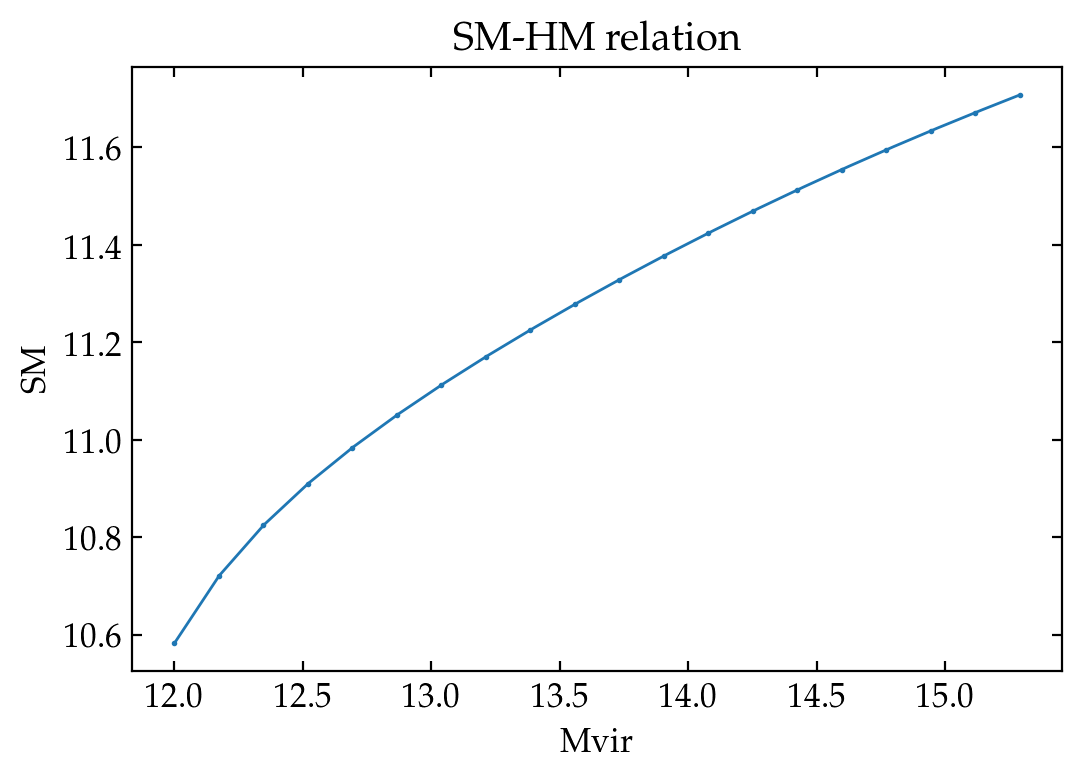

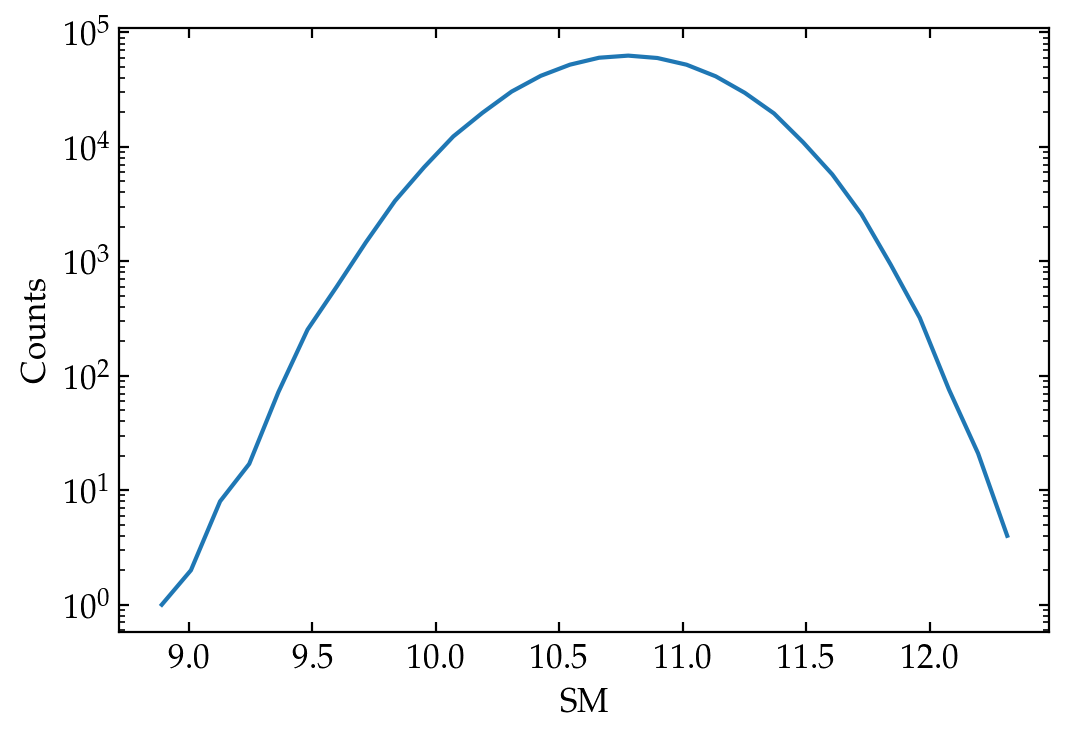

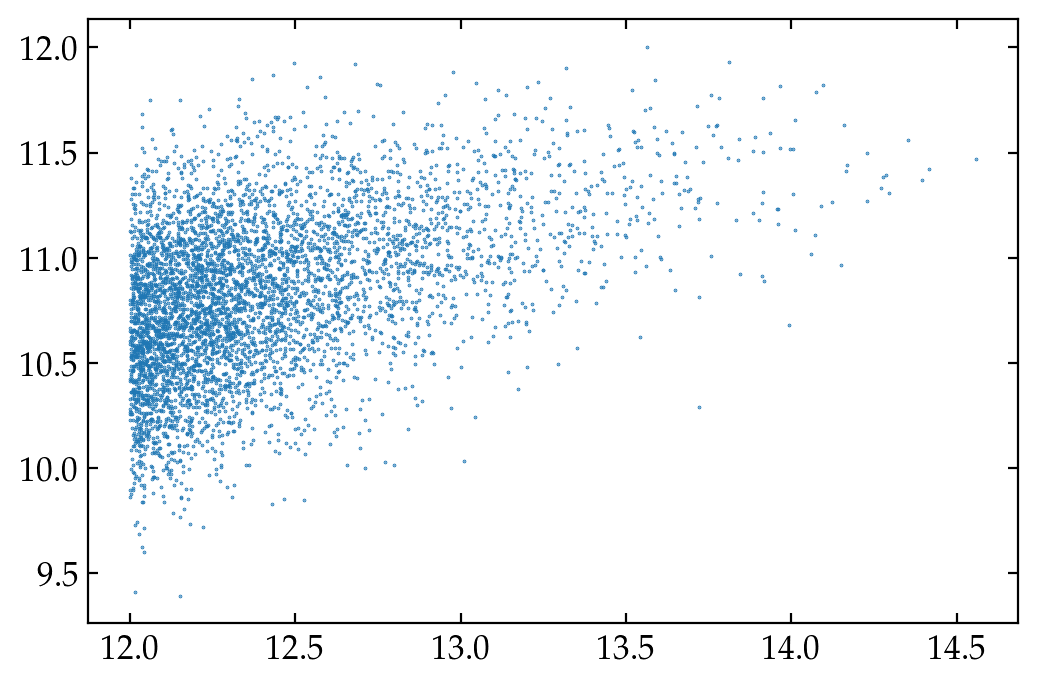

In [10]:
_sanity_get_sm_for_sim(sim_data, b_params, s_params)

## Detect clustering in the sim

In [35]:
lower_mass_cut = 11.65
upper_mass_cut = 11.75

s1 = sim_data[log_stellar_masses > upper_mass_cut]
s2 = sim_data[(log_stellar_masses > lower_mass_cut) & (log_stellar_masses < upper_mass_cut)]
randoms = gop.sim_size * np.random.random(size=(5000000, 3))
randoms = randoms.ravel().view([("halo_x", np.float64), ("halo_y", np.float64), ("halo_z", np.float64)])

dd = np.sum(c.sim_clustering(s1, s2))
dr = np.sum(c.sim_clustering(s1, randoms))
obs_clust = c.compute_clustering(dd, dr, len(s2), len(randoms))
print(obs_clust)

/home/christopher/research/satellite_fraction/cb/clustering.py:12: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  s1[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),
/home/christopher/research/satellite_fraction/cb/clustering.py:13: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  s2[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),


7.991434438431291


## Detect clustering in hsc

In [47]:
randoms = gop.load_randoms()
randoms = np.random.choice(randoms, 50000) # 1 in 10 just to make things quicker while in dev

s1 = gals[gals["logm_max"] > upper_mass_cut]
s2 = gals[
    (gals["logm_max"] > lower_mass_cut) & (gals["logm_max"] < upper_mass_cut)
]

# We need to ensure that the randoms have the same redshift distribution as s2
hist, edges = np.histogram(s2["z_best"], bins=100)
cdf = np.append(0, np.cumsum(hist))
cdf = cdf / cdf[-1]
f = scipy.interpolate.interp1d(cdf, edges)
randoms["z_best"] = f(randoms["z_best"])

dd = c.obs_clustering(s1, s2, True)
dr = c.obs_clustering(s1, randoms)
#rr = c.obs_clustering(randoms, randoms)

obs_clust = c.compute_clustering(dd, dr, len(s2), len(randoms))
print(obs_clust)

41
41
30.11718275652702


## Compare to HSC SMF

In [22]:
# Some confusion about whether this is actually the SMF that we want but I'm going with it for now...

smf_bins = np.append(obs_smf["logm_0"], obs_smf["logm_1"][-1])
smf_centers = obs_smf["logm_mean"]

sim_smf = get_smf(log_stellar_masses, smf_bins, 1000**3)

### Sanity check HSC SMF

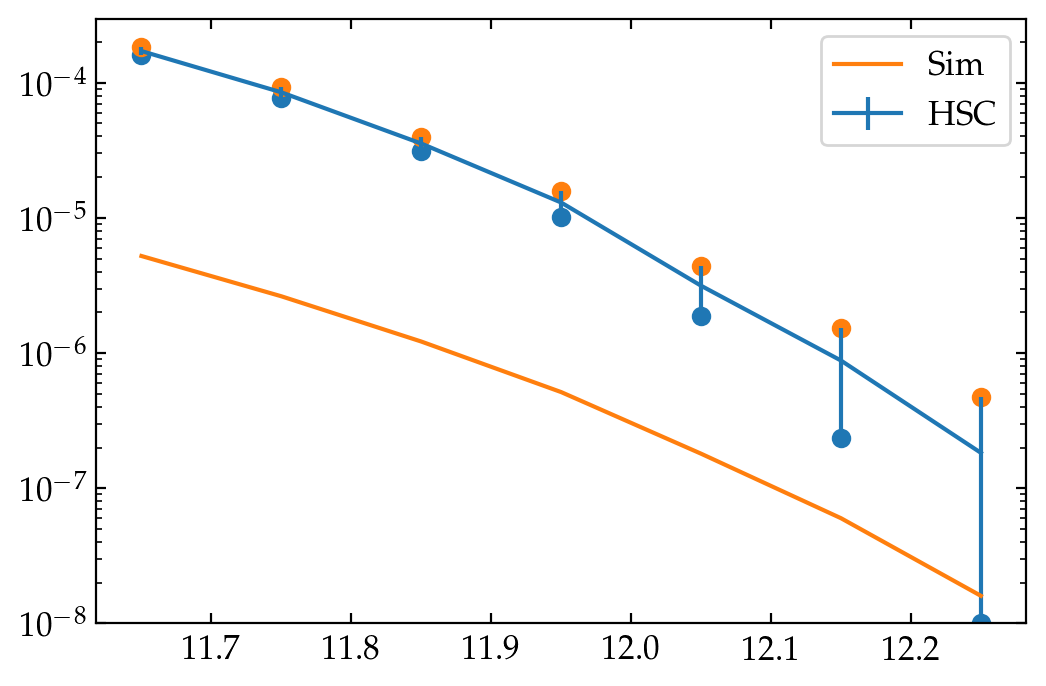

In [23]:
_, ax = plt.subplots()
ax.errorbar(obs_smf["logm_mean"], obs_smf["smf"], yerr=obs_smf["smf_err"], label="HSC")
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_low"])
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_upp"])

ax.set(yscale="log")


ax.plot(smf_centers, sim_smf, label="Sim")
ax.legend()

## Likelihood

In [212]:
l.compute_likelihood(smf, sim_smf)

15.149852233888833

# Now put in MCMC 

In [43]:
nwalkers = 64
params = b_params + s_params
ndim = len(params)
start_positions = np.array([params * (np.random.random(size=ndim)/20 + 0.975) for i in range(nwalkers)]) # peturbed best fit positions

sampler = emcee.EnsembleSampler(nwalkers, ndim, l.single_step, args=[sim_data, obs_smf], threads=32)
_ = sampler.run_mcmc(start_positions, 100) # Roughly 30s per step

negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatt

In [ ]:
sampler.run_mcmc(None, 1500)

## Plot MCMC

49.961758023056426
[12.33361471 11.06954566  0.59570586 -0.0612304   1.06639163]
[12.52, 10.91, 0.6] [-0.06, 1.08]


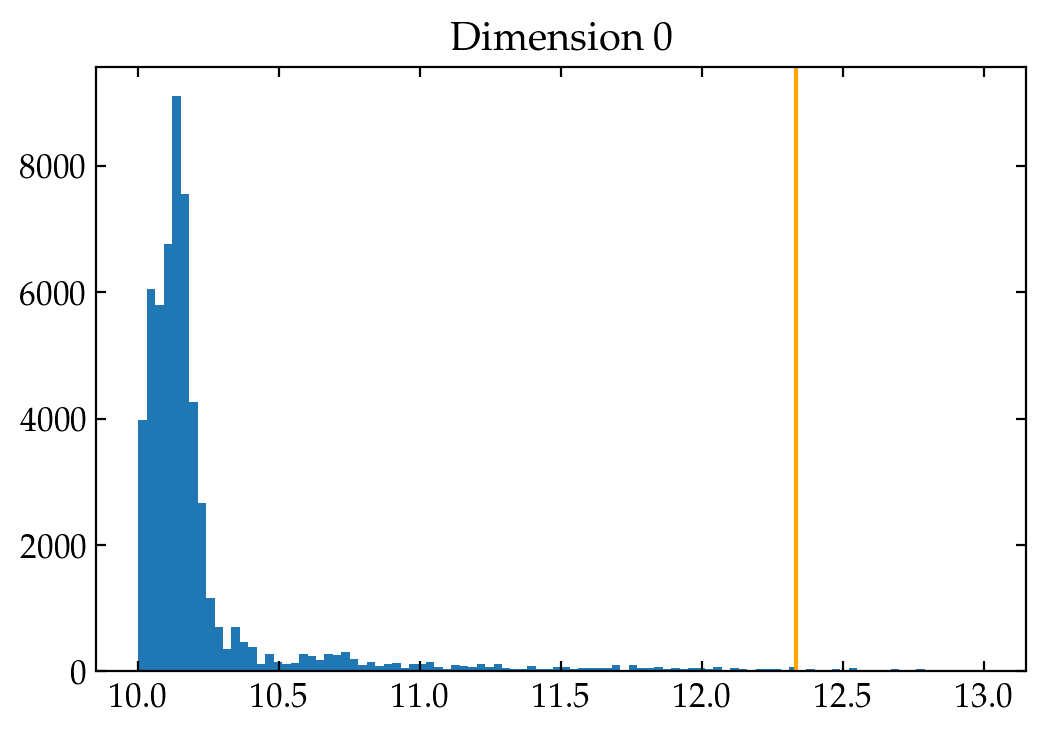

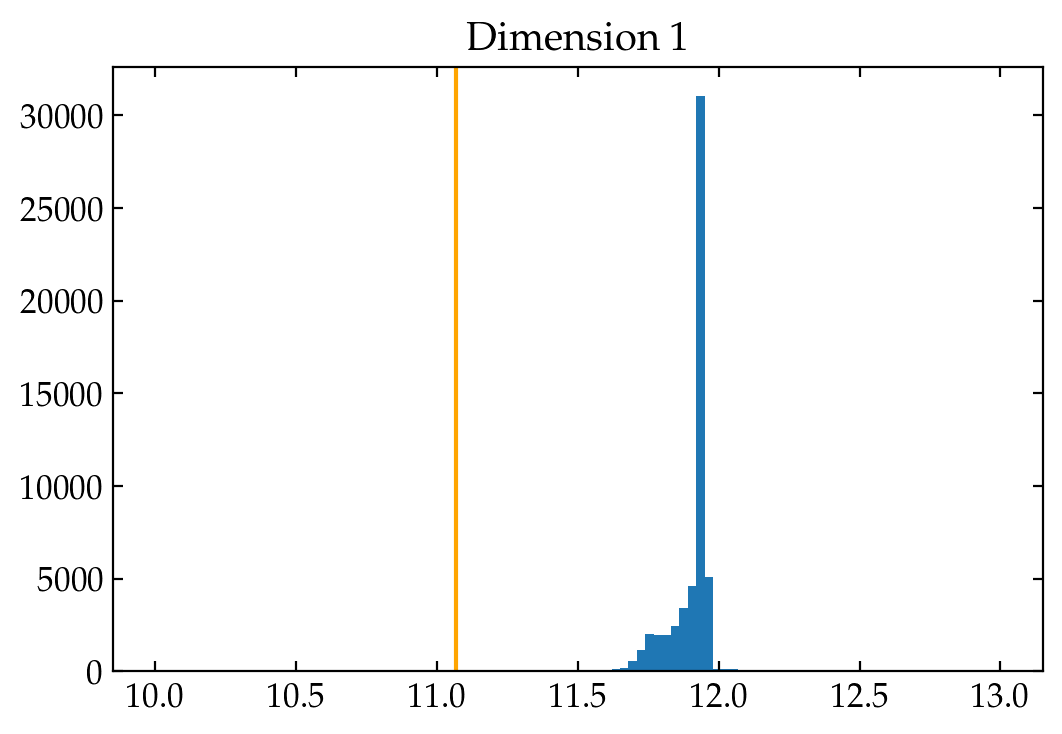

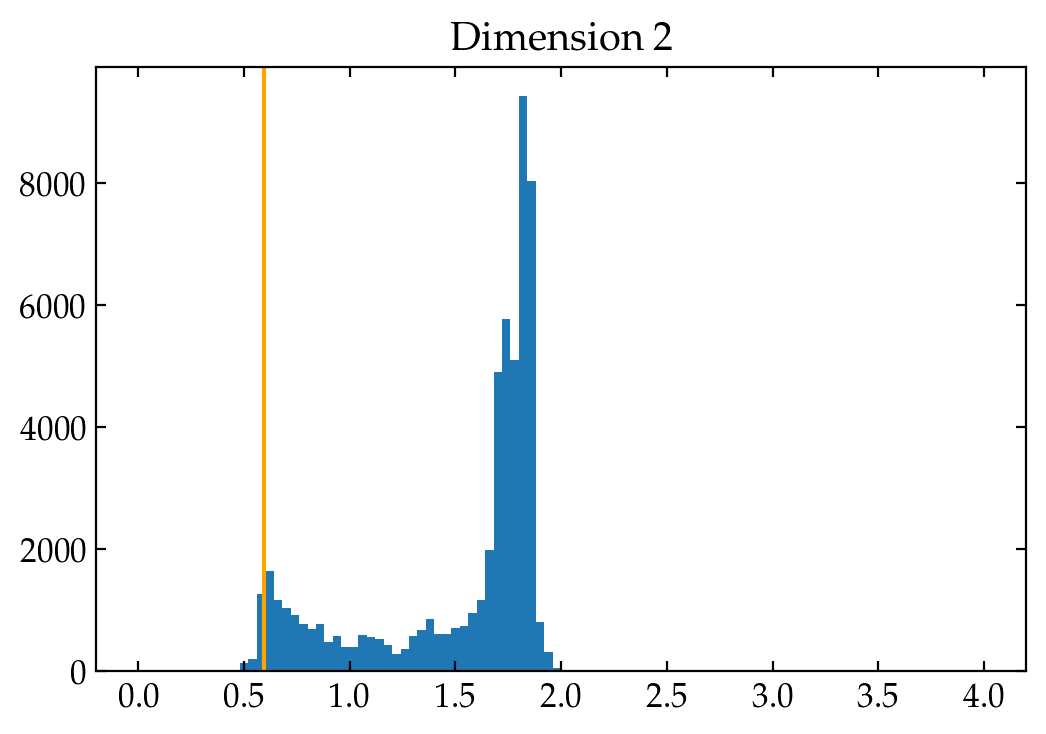

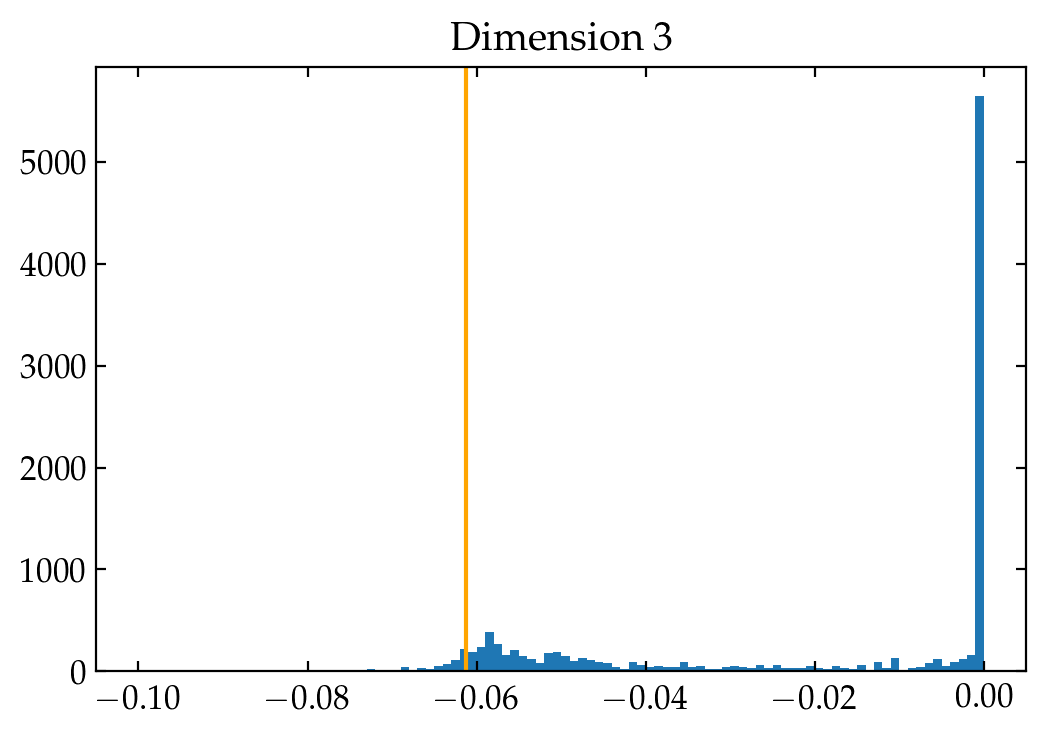

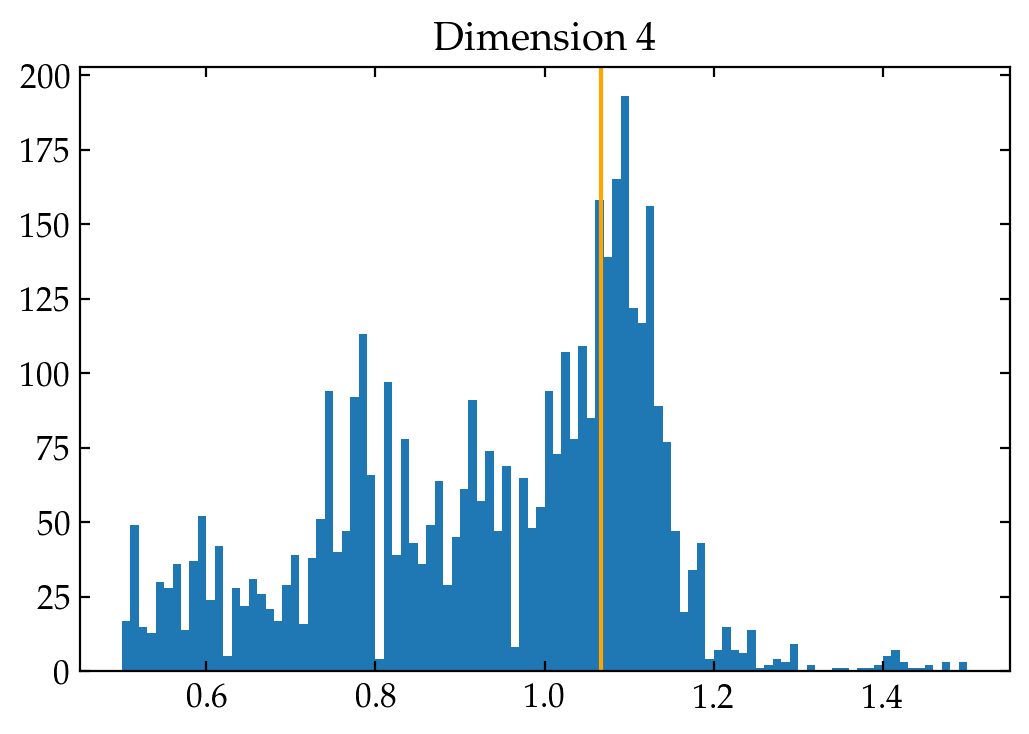

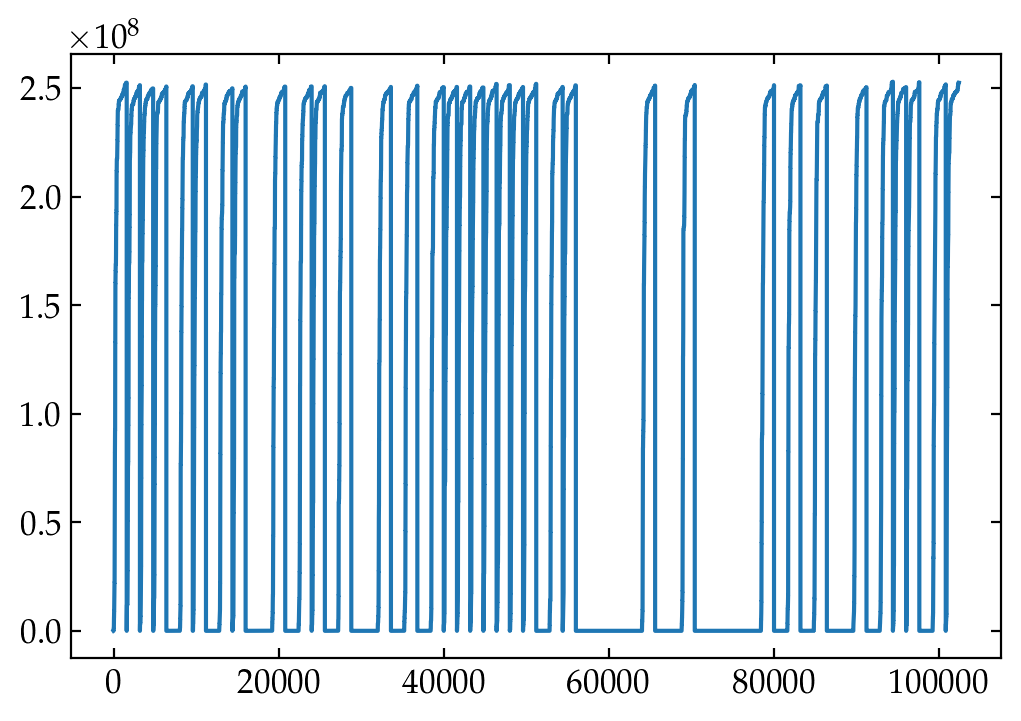

In [65]:
best_p = sampler.flatchain[
    sampler.flatlnprobability == np.min(sampler.flatlnprobability)
][0]
print(np.min(sampler.flatlnprobability))
print(best_p)
print(b_params, s_params)

ranges =[(10, 13), (10, 13), (0, 4), (-0.1, 0), (0.5, 1.5)]
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], bins=100, range=ranges[i])
    #ax.plot(sampler.chain[3,:,i])
    ax.set(title="Dimension {0:d}".format(i))
    ax.axvline(best_p[i], color="orange")

_, ax = plt.subplots()
ax.plot(sampler.flatlnprobability)

# Bestfit
(But remember that MCMC is bad at finding the bestfit!)

48.55316364541634

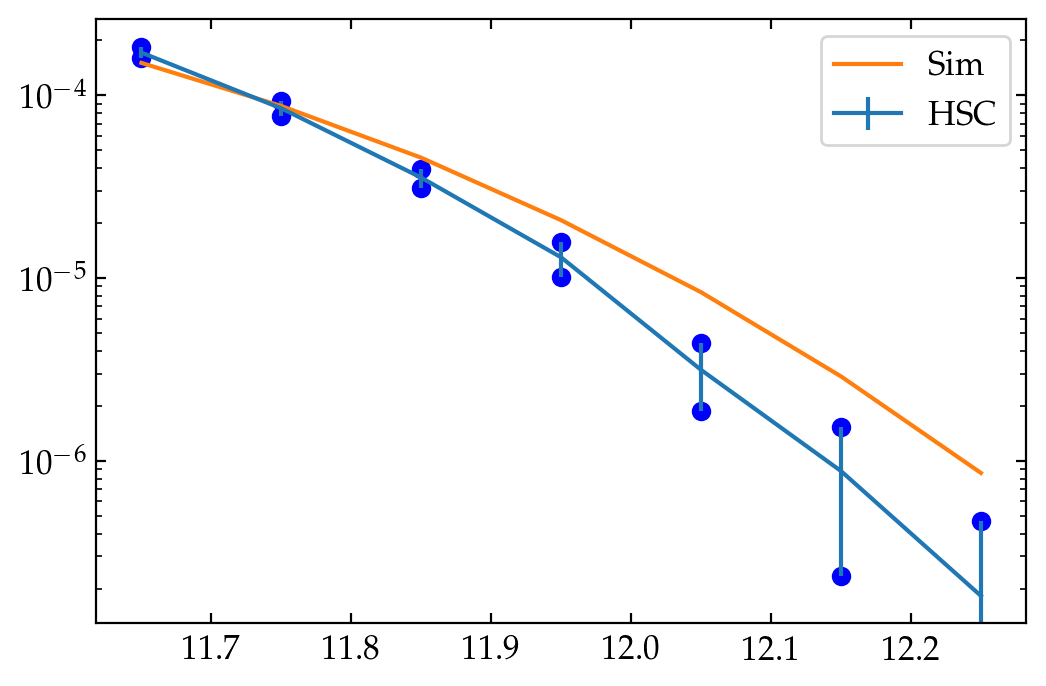

In [66]:
log_stellar_masses = get_sm_for_sim(sim_data, best_p[:3], best_p[3:])
#log_stellar_masses = get_sm_for_sim(sim_data, b_params, s_params)

smf_bins = np.append(obs_smf["logm_0"], obs_smf["logm_1"][-1])
smf_centers = obs_smf["logm_mean"]

sim_smf = get_smf(log_stellar_masses, smf_bins, 1000**3)

_, ax = plt.subplots()
ax.errorbar(obs_smf["logm_mean"], obs_smf["smf"], yerr=obs_smf["smf_err"], label="HSC")
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_low"], color="b")
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_upp"], color="b")

ax.set(yscale="log")

ax.plot(smf_centers, sim_smf, label="Sim")
ax.legend()

l.compute_likelihood(obs_smf, sim_smf)

# Try find bestfit with optimizer

In [29]:
params = b_params + s_params
res = scipy.optimize.minimize(
    l.single_step_avg,
    x0 = params,
    args=(sim_data, obs_smf, 1),
    method="Powell",
)

[12.52 10.91  0.6  -0.06  1.08]
103.61751210460623
[12.52 10.91  0.6  -0.06  1.08]
103.20615172743717
[13.52 10.91  0.6  -0.06  1.08]
408.43310015138724
[10.901966 10.91      0.6      -0.06      1.08    ]
89318.99049901376
[12.52 10.91  0.6  -0.06  1.08]
104.7461567109618
[11.90196603 10.91        0.6        -0.06        1.08      ]
1317.698331516298
[12.901966 10.91      0.6      -0.06      1.08    ]
311.6954790085361
[12.60281323 10.91        0.6        -0.06        1.08      ]
154.97921909392477
[12.28393203 10.91        0.6        -0.06        1.08      ]
26.704276640733628
[12.21098362 10.91        0.6        -0.06        1.08      ]
70.55603076365702
[12.34714404 10.91        0.6        -0.06        1.08      ]
26.11580958873838
[12.31660894 10.91        0.6        -0.06        1.08      ]
25.95638814894725
[12.32600589 10.91        0.6        -0.06        1.08      ]
26.907225516680196
[12.31457503 10.91        0.6        -0.06        1.08      ]
31.99696739430384
[12.32019826 1

/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


29.381834657925225
[12.31660894 10.89845593 -0.01803397 -0.06        1.08      ]
416.9908029623121
[12.31660894 10.89845593  0.981966   -0.06        1.08      ]
61.93385081240451
[12.31660894 10.89845593  0.73116838 -0.06        1.08      ]
37.28757173736029
[12.31660894 10.89845593  0.36393203 -0.06        1.08      ]
213.48622364695865
[12.31660894 10.89845593  0.50983006 -0.06        1.08      ]
34.585891255794756
[12.31660894 10.89845593  0.60905002 -0.06        1.08      ]
29.286658260722128
[12.31660894 10.89845593  0.61557935 -0.06        1.08      ]
29.11991837601597
[12.31660894 10.89845593  0.65973043 -0.06        1.08      ]
33.35710037947049
[12.31660894 10.89845593  0.63244356 -0.06        1.08      ]
28.710879252020874
[12.31660894 10.89845593  0.64286622 -0.06        1.08      ]
32.27325315113167
[12.31660894 10.89845593  0.626002   -0.06        1.08      ]
31.621014955100208
[12.31660894 10.89845593  0.63642466 -0.06        1.08      ]
28.426026837481114
[12.31660894 10

11504.979407740106
[12.22316932 10.89315248  0.65315847 -0.0599929   0.96245814]
340.34783707199927
[12.22316932 10.89315248  0.65315847 -0.0599929   1.13592348]
905.3274345723978
[12.22316932 10.89315248  0.65315847 -0.0599929   1.03522376]
94.53503431627232
[12.22316932 10.89315248  0.65315847 -0.0599929   1.10231887]
161.53332703750266
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06427179]
24.004740677523255
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06964167]
17.333573229037043
[12.22316932 10.89315248  0.65315847 -0.0599929   1.07116261]
19.42724088395257
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06859114]
18.290505900102993
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06953613]
16.202704505381362
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06915342]
19.39733597647543
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06938995]
21.18524882366527
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06953613]
17.979502979907394
[12.22316932 1

/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


96.12889401330582
[12.22316932 10.89315248 -0.96487553 -0.0599929   1.06953613]
416.9908029623121
[12.22316932 10.89315248  0.65315847 -0.0599929   1.06953613]
17.515525955745762
[12.22316932 10.89315248  0.03512449 -0.0599929   1.06953613]
416.9908029623121
[12.22316932 10.89315248  1.03512447 -0.0599929   1.06953613]
55.19832297992197
[12.22316932 10.89315248  0.77793189 -0.0599929   1.06953613]
30.561907986395504
[12.22316932 10.89315248  0.4170905  -0.0599929   1.06953613]
134.69901982959675
[12.22316932 10.89315248  0.56298853 -0.0599929   1.06953613]
22.05197356227144
[12.22316932 10.89315248  0.64298586 -0.0599929   1.06953613]
19.86827363435673
[12.22316932 10.89315248  0.70081767 -0.0599929   1.06953613]
21.407063613846084
[12.22316932 10.89315248  0.66944314 -0.0599929   1.06953613]
19.939684725864062
[12.22316932 10.89315248  0.65612057 -0.0599929   1.06953613]
19.669590267115858
[12.22316932 10.89315248  0.64965686 -0.0599929   1.06953613]
18.313298598590126
[12.22316932 10

9.304726753059677
[12.1297297  10.89089203  0.67032444 -0.06017821  1.0631541 ]
11.641937106821722
[12.1297297  10.89041724  0.67032444 -0.06017821  1.0631541 ]
10.036849235818373
[12.1297297  10.8902253   0.67032444 -0.06017821  1.0631541 ]
12.160354939139028
[12.1297297  10.89016257  0.67032444 -0.06017821  1.0631541 ]
9.883587858742873
[12.1297297  10.8901238   0.67032444 -0.06017821  1.0631541 ]
8.853250491194725
[12.1297297  10.8901238   1.67032444 -0.06017821  1.0631541 ]
94.53538652589924
[12.1297297  10.8901238  -0.94770956 -0.06017821  1.0631541 ]
416.9908029623121
[12.1297297  10.8901238   0.67032444 -0.06017821  1.0631541 ]


/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


12.321332385312832
[12.1297297  10.8901238   0.05229046 -0.06017821  1.0631541 ]
416.9908029623121
[12.1297297  10.8901238   1.05229044 -0.06017821  1.0631541 ]
48.520225691283315
[12.1297297  10.8901238   0.79808862 -0.06017821  1.0631541 ]
19.10699482939423
[12.1297297  10.8901238   0.57216664 -0.06017821  1.0631541 ]
19.370335614513102
[12.1297297  10.8901238   0.68618163 -0.06017821  1.0631541 ]
8.818892014314024
[12.1297297  10.8901238   0.72336017 -0.06017821  1.0631541 ]
12.395575264822696
[12.1297297  10.8901238   0.70038257 -0.06017821  1.0631541 ]
11.352353929419412
[12.1297297  10.8901238   0.68656693 -0.06017821  1.0631541 ]
9.350119572416364
[12.1297297  10.8901238   0.68012472 -0.06017821  1.0631541 ]
12.441057443148052
[12.1297297  10.8901238   0.6838681  -0.06017821  1.0631541 ]
11.119091396751532
[12.1297297  10.8901238   0.68559024 -0.06017821  1.0631541 ]
10.529219044367906
[12.1297297  10.8901238   0.6863402  -0.06017821  1.0631541 ]
10.749461824543417
[12.1297297  

9.611330036855426
[12.06304677 10.89240776  0.70792395 -0.06034255  1.05921568]
5.560379742037501
[12.06304677 10.8906267   0.70792395 -0.06034255  1.05921568]
8.106360123662293
[12.06304677 10.89172745  0.70792395 -0.06034255  1.05921568]
7.628846594971034
[12.06304677 10.8921479   0.70792395 -0.06034255  1.05921568]
5.725299998843847
[12.06304677 10.89228132  0.70792395 -0.06034255  1.05921568]
4.748634219485051
[12.06304677 10.89232669  0.70792395 -0.06034255  1.05921568]
5.21797641549972
[12.06304677 10.89223036  0.70792395 -0.06034255  1.05921568]
5.591522091413543
[12.06304677 10.89228132  0.70792395 -0.06034255  1.05921568]
4.390699620946169
[12.06304677 10.89228132  1.70792395 -0.06034255  1.05921568]


/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


89.66027567981419
[12.06304677 10.89228132 -0.91011005 -0.06034255  1.05921568]
416.9908029623121
[12.06304677 10.89228132  0.70792395 -0.06034255  1.05921568]
7.055442681144223
[12.06304677 10.89228132  0.08988998 -0.06034255  1.05921568]
416.9908029623121
[12.06304677 10.89228132  1.08988995 -0.06034255  1.05921568]
41.90547020561303
[12.06304677 10.89228132  0.83844626 -0.06034255  1.05921568]
13.215891206462485
[12.06304677 10.89228132  0.63844721 -0.06034255  1.05921568]
14.66811671255799
[12.06304677 10.89228132  0.74307844 -0.06034255  1.05921568]
5.014607864605255
[12.06304677 10.89228132  0.75180203 -0.06034255  1.05921568]
8.160515220339573
[12.06304677 10.89228132  0.72854326 -0.06034255  1.05921568]
5.4843801148877365
[12.06304677 10.89228132  0.7375265  -0.06034255  1.05921568]
5.904793461328778
[12.06304677 10.89228132  0.74641056 -0.06034255  1.05921568]
7.653667806307245
[12.06304677 10.89228132  0.74095779 -0.06034255  1.05921568]
6.604879597878651
[12.06304677 10.8922

/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


6.4423711558509575
[12.02660188 10.27690717  0.78479837 -0.06015904  1.05396815]
415.8646475965426
[12.02660188 11.27690714  0.78479837 -0.06015904  1.05396815]
54191.54536913513
[12.02660188 10.58824823  0.78479837 -0.06015904  1.05396815]
370.56573928243637
[12.02660188 11.04083917  0.78479837 -0.06015904  1.05396815]
1384.7752620949204
[12.02660188 10.77779488  0.78479837 -0.06015904  1.05396815]
164.42986641713293
[12.02660188 10.95066923  0.78479837 -0.06015904  1.05396815]
92.42316428646086
[12.02660188 10.87668351  0.78479837 -0.06015904  1.05396815]
15.600872512317181
[12.02660188 10.89488872  0.78479837 -0.06015904  1.05396815]
5.385355848447228
[12.02660188 10.88603331  0.78479837 -0.06015904  1.05396815]
8.049924708107854
[12.02660188 10.89150625  0.78479837 -0.06015904  1.05396815]
6.636417448462395
[12.02660188 10.89322842  0.78479837 -0.06015904  1.05396815]
6.2442149510901555
[12.02660188 10.89407999  0.78479837 -0.06015904  1.05396815]
7.713086111290513
[12.02660188 10.

/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


6.259921633820273
[12.02660188 10.89488743  0.16676439 -0.06015904  1.05396815]
26377.62555870857
[12.02660188 10.89488743  1.16676437 -0.06015904  1.05396815]
40.56659818875757
[12.02660188 10.89488743  0.97473112 -0.06015904  1.05396815]
23.146092333872375
[12.02660188 10.89488743  0.5487304  -0.06015904  1.05396815]
74.24887042681192
[12.02660188 10.89488743  0.69462843 -0.06015904  1.05396815]
8.682309180990893
[12.02660188 10.89488743  0.77221242 -0.06015904  1.05396815]
8.167384202957665
[12.02660188 10.89488743  0.85734622 -0.06015904  1.05396815]
8.255282377441828
[12.02660188 10.89488743  0.81453388 -0.06015904  1.05396815]
7.681344395064444
[12.02660188 10.89488743  0.79459217 -0.06015904  1.05396815]
6.336471469365977
[12.02660188 10.89488743  0.78774624 -0.06015904  1.05396815]
6.6488186709703845
[12.02660188 10.89488743  0.77999096 -0.06015904  1.05396815]
6.753895223871164
[12.02660188 10.89488743  0.7829621  -0.06015904  1.05396815]
6.277828535864878
[12.02660188 10.8948

/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:96: RuntimeWarning: overflow encountered in multiply
  ((delta * np.power(usm, delta - 1)) / (sm0 * denom)) +
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


416.9908029623121
[11.93074072 10.90272728  0.90379914 -0.0598833   1.04168178]
3.549676528238895
[11.93074072 10.28469331  0.90379914 -0.0598833   1.04168178]
415.84479112438015
[11.93074072 11.28469328  0.90379914 -0.0598833   1.04168178]
57590.65296609967
[11.93074072 10.59591296  0.90379914 -0.0598833   1.04168178]
369.7515579938419
[11.93074072 11.04862531  0.90379914 -0.0598833   1.04168178]
1402.5704371863812
[11.93074072 10.78553464  0.90379914 -0.0598833   1.04168178]
169.86384001542802
[11.93074072 10.95845537  0.90379914 -0.0598833   1.04168178]
107.41381909508581
[11.93074072 10.88150636  0.90379914 -0.0598833   1.04168178]
14.646731825571619
[11.93074072 10.90054666  0.90379914 -0.0598833   1.04168178]
2.994861065860852
[11.93074072 10.89852103  0.90379914 -0.0598833   1.04168178]
3.9993739793143983
[11.93074072 10.90092382  0.90379914 -0.0598833   1.04168178]
3.8029786587770364
[11.93074072 10.89977294  0.90379914 -0.0598833   1.04168178]
3.721764806555609
[11.93074072 10

/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


85.64701517273596
[11.93074072 10.90018136 -0.71423486 -0.0598833   1.04168178]
416.9908029623121
[11.93074072 10.90018136  0.90379914 -0.0598833   1.04168178]
3.585078059238108
[11.93074072 10.90018136  0.28576517 -0.0598833   1.04168178]
7464.788325376368
[11.93074072 10.90018136  1.28576514 -0.0598833   1.04168178]
37.56209601139066
[11.93074072 10.90018136  1.09112496 -0.0598833   1.04168178]
18.67022829904085
[11.93074072 10.90018136  0.66773117 -0.0598833   1.04168178]
40.294932376425486
[11.93074072 10.90018136  0.8136292  -0.0598833   1.04168178]
5.304983074093742
[11.93074072 10.90018136  0.88528449 -0.0598833   1.04168178]
2.6363396424532812
[11.93074072 10.90018136  0.86843276 -0.0598833   1.04168178]
3.7385171374372104
[11.93074072 10.90018136  0.88677366 -0.0598833   1.04168178]
2.8811323660148482
[11.93074072 10.90018136  0.8788477  -0.0598833   1.04168178]
3.3513551345667345
[11.93074072 10.90018136  0.88366418 -0.0598833   1.04168178]
2.655031588468608
[11.93074072 10.9

2.7528695699659167
[11.93074095 10.90018134  0.88528422 -0.0598833   1.04168181]
3.6538659233046777
[11.93074094 10.90018134  0.88528423 -0.0598833   1.04168181]
2.762492942064127
[11.94631163 10.89724856  0.85512363 -0.05982639  1.0452707 ]
2.5027294095140196
[11.93074095 10.90018134  0.88528423 -0.0598833   1.04168181]
3.029066121225817
[11.91351264 10.90060938  0.89816988 -0.05994627  1.03771083]
3.6394204193958704
[11.95861693 10.89948877  0.86443481 -0.05978142  1.04810699]
5.542139361824026
[11.93074095 10.90018134  0.88528423 -0.0598833   1.04168181]
3.5913679230996136
[11.94138862 10.8999168   0.87732046 -0.05984438  1.04413601]
3.1447941077001182
[11.94796925 10.89975331  0.87239858 -0.05982033  1.04565279]
3.762292325804834
[11.93872567 10.89998296  0.87931218 -0.05985412  1.04352222]
2.5994230322407725
[11.93674341 10.90003221  0.88079478 -0.05986136  1.04306533]
3.430810685874677
[11.93929512 10.89996882  0.87888627 -0.05985204  1.04365348]
3.7883458138084833
[11.93796851 1

/home/christopher/research/hsc_um2/cb/smhm_fit.py:96: RuntimeWarning: overflow encountered in multiply
  ((delta * np.power(usm, delta - 1)) / (sm0 * denom)) +
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


416.9908029623121
[11.93872567 10.89998296  0.87931218 -0.05985412  1.04352222]
2.725005583655372
[11.93872567 10.28194899  0.87931218 -0.05985412  1.04352222]
415.79866754096105
[11.93872567 11.28194896  0.87931218 -0.05985412  1.04352222]
59121.59675436074
[11.93872567 10.59311585  0.87931218 -0.05985412  1.04352222]
368.70783169835687
[11.93872567 11.04588099  0.87931218 -0.05985412  1.04352222]
1473.324618783018
[11.93872567 10.78277016  0.87931218 -0.05985412  1.04352222]
163.73103688742378
[11.93872567 10.95571105  0.87931218 -0.05985412  1.04352222]
115.02787901347163
[11.93872567 10.87642647  0.87931218 -0.05985412  1.04352222]
16.963570070653805
[11.93872567 10.8973516   0.87931218 -0.05985412  1.04352222]
3.590996086470247
[11.93872567 10.91117282  0.87931218 -0.05985412  1.04352222]
7.119415017705798
[11.93872567 10.90425711  0.87931218 -0.05985412  1.04352222]
4.0777795042820015
[11.93872567 10.90042736  0.87931218 -0.05985412  1.04352222]
4.72789145253012
[11.93872567 10.8

/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
/home/christopher/research/hsc_um2/cb/smhm_fit.py:93: RuntimeWarning: overflow encountered in power
  denom = (usm**-gamma) + 1
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:81: RuntimeWarning: overflow encountered in power
  log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5


78.2372831308109
[11.93872567 10.89998681 -0.73872182 -0.05985412  1.04352222]
416.9908029623121
[11.93872567 10.89998681  0.87931218 -0.05985412  1.04352222]
2.970542924052994
[11.93872567 10.89998681  0.2612782  -0.05985412  1.04352222]
11520.583544903839
[11.93872567 10.89998681  1.26127818 -0.05985412  1.04352222]
31.420972219715548
[11.93872567 10.89998681  1.06830473 -0.05985412  1.04352222]
14.58145000238969
[11.93872567 10.89998681  0.64324421 -0.05985412  1.04352222]
66.0976451798966
[11.93872567 10.89998681  0.78914224 -0.05985412  1.04352222]
8.445411005246099
[11.93872567 10.89998681  0.90360728 -0.05985412  1.04352222]
2.745974845164151
[11.93872567 10.89998681  0.90173718 -0.05985412  1.04352222]
2.9077891905334132
[11.93872567 10.89998681  0.96651611 -0.05985412  1.04352222]
6.686272846349387
[11.93872567 10.89998681  0.92763632 -0.05985412  1.04352222]
4.900231006692797
[11.93872567 10.89998681  0.91278556 -0.05985412  1.04352222]
4.691887156053153
[11.93872567 10.89998

3.388100771272355

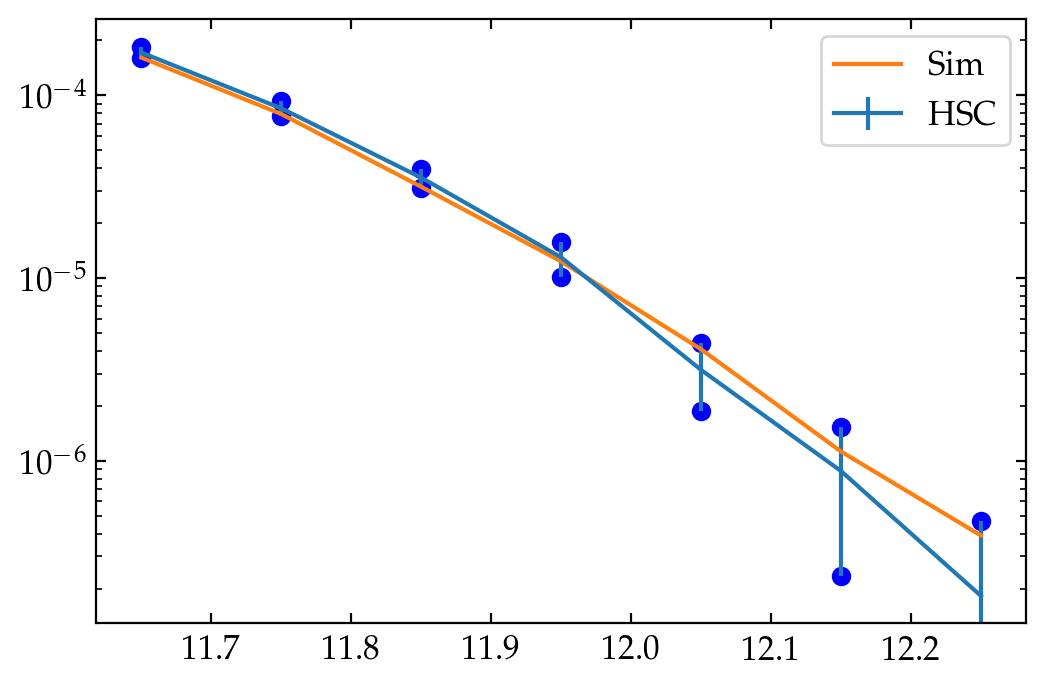

In [37]:
best_p = res.x

log_stellar_masses = get_sm_for_sim(sim_data, best_p[:3], best_p[3:])
#log_stellar_masses = get_sm_for_sim(sim_data, b_params, s_params)

smf_bins = np.append(obs_smf["logm_0"], obs_smf["logm_1"][-1])
smf_centers = obs_smf["logm_mean"]

sim_smf = get_smf(log_stellar_masses, smf_bins, gop.sim_size**3)

_, ax = plt.subplots()
ax.errorbar(obs_smf["logm_mean"], obs_smf["smf"], yerr=obs_smf["smf_err"], label="HSC")
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_low"], color="b")
ax.scatter(obs_smf["logm_mean"], obs_smf["smf_upp"], color="b")

ax.set(yscale="log")

ax.plot(smf_centers, sim_smf, label="Sim")
ax.legend()

l.compute_likelihood(obs_smf, sim_smf)